In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
import matplotlib.gridspec as gridspec
from mplsoccer import add_image

from PIL import Image
import urllib
import json
import os

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("soc_base.mplstyle")

In [3]:
#this is single game xG data from the good folks at fbref
data = pd.read_csv('../data/team_games_wsl.csv',)

In [4]:
data

,Wk,Day,Date,Time,Home,Home_xG,Score,Away_xG,Away,Attendance,Venue,Referee
0,1,Fri,20/9/2024,19:00 (20:00),Chelsea,1.1,1–0,0.9,Aston Villa,"4,337",Cherry Red Records Fans' Stadium,Kirsty Dowle
1,1,Sat,21/9/2024,12:00 (13:00),Manchester Utd,1.2,3–0,0.9,West Ham,"8,761",Old Trafford,Cheryl Foster
2,1,Sat,21/9/2024,12:30 (13:30),Brighton,2.1,4–0,0.5,Everton,"2,125",Broadfield Stadium,Lauren Impey
3,1,Sun,22/9/2024,12:30 (13:30),Arsenal,2.2,2–2,1.4,Manchester City,"41,818",Emirates Stadium,Abigail Byrne
4,1,Sun,22/9/2024,14:00 (15:00),Tottenham,4.1,4–0,0.3,Crystal Palace,"1,778",Brisbane Road,Amy Fearn
...,...,...,...,...,...,...,...,...,...,...,...,...
127,22,Sat,10/5/2025,12:30 (13:30),Arsenal,1.9,4–3,1.6,Manchester Utd,"46,603",Emirates Stadium,Melissa Burgin
128,22,Sat,10/5/2025,12:30 (13:30),Chelsea,1.3,1–0,0.3,Liverpool,"21,327",Stamford Bridge,Phoebe Cross
129,22,Sat,10/5/2025,12:30 (13:30),Aston Villa,1.8,3–1,1.7,Brighton,"3,492",Villa Park,Lisa Benn
130,22,Sat,10/5/2025,12:30 (13:30),Everton,0.4,1–1,0.3,Tottenham,891,Walton Hall Park,Stacey Fullicks


In [5]:
#create empty list
match_data = []
#iterate through dataframe
for i in range(data.shape[0]):
    home_xg = data.Home_xG.iloc[i]
    away_xg = data.Away_xG.iloc[i]
    home_team = data.Home.iloc[i]
    away_team = data.Away.iloc[i]
    date = data.Date.iloc[i]
    ref = data.Referee.iloc[i]

    home_for = {"date": date, "referee": ref, "variable": "xG_for", "value": home_xg, "venue": "H",  "team_name": home_team}
    home_ag = {"date": date, "referee": ref, "variable": "xG_ag", "value": away_xg, "venue": "H",  "team_name": home_team}
    away_for = {"date": date, "referee": ref, "variable": "xG_for", "value": away_xg, "venue": "A",  "team_name": away_team}
    away_ag = {"date": date, "referee": ref, "variable": "xG_ag", "value": home_xg, "venue": "A",  "team_name": away_team}

    match_data.append(home_for)
    match_data.append(home_ag)
    match_data.append(away_for)
    match_data.append(away_ag)

df = pd.DataFrame(match_data)

In [6]:
#we want to be able to get team logos from the good folks over at Fotmob. I ended up not using them because I didn't have the space
fotmob = pd.read_csv('../data/fotmob_fbref.csv')
df = pd.merge(left=df, right=fotmob, left_on='team_name', right_on='name', how='left')
df['team_id'] = df['fotmob_id']
df = df.drop(['name','fotmob_id'], axis =1)

In [7]:
df

,date,referee,variable,value,venue,team_name,team_id
0,20/9/2024,Kirsty Dowle,xG_for,1.1,H,Chelsea,258661
1,20/9/2024,Kirsty Dowle,xG_ag,0.9,H,Chelsea,258661
2,20/9/2024,Kirsty Dowle,xG_for,0.9,A,Aston Villa,231494
3,20/9/2024,Kirsty Dowle,xG_ag,1.1,A,Aston Villa,231494
4,21/9/2024,Cheryl Foster,xG_for,1.2,H,Manchester Utd,954396
...,...,...,...,...,...,...,...
523,10/5/2025,Stacey Fullicks,xG_ag,0.4,A,Tottenham,628117
524,10/5/2025,Lucy May,xG_for,2.1,H,Leicester City,614954
525,10/5/2025,Lucy May,xG_ag,1.6,H,Leicester City,614954
526,10/5/2025,Lucy May,xG_for,1.6,A,West Ham,231497


In [8]:
top_10 = df.team_id.unique()
top_10_colors=[
    '#ed2227', '#2a4b80', '#8c2d42', '#ac152a',
    '#7f1734', '#000000', '#faac28', '#000000',
    '#182544', '#00669d', '#528050', '#29756e'
]

In [9]:
def plot_scatter_xg(ax, team_id, color='red', label_x=False, label_y=False):
    '''
    This function plots the scatter xG of all matches in League Two.
    '''
    ax.grid(ls='--', color='lightgrey')
    # ----------------------------------------------------------------
    # -- Filter data
    df_aux_h = df[(df['team_id'] == team_id) & (df['venue'] == 'H')]
    df_aux_a = df[(df['team_id'] == team_id) & (df['venue'] == 'A')]
    # ----------------------------------------------------------------
    # -- Scatter plots
    ax.scatter(
        df[df['variable'] == 'xG_ag']['value'], df[df['variable'] == 'xG_for']['value'], 
        alpha=.1, lw=1,
        zorder=3, s=20
    )
    ax.scatter(
        df_aux_h[df_aux_h['variable'] == 'xG_ag']['value'], df_aux_h[df_aux_h['variable'] == 'xG_for']['value'], 
        alpha=1, lw=1, ec='black', fc=color,
        zorder=3, s=40
    )
    ax.scatter(
        df_aux_a[df_aux_a['variable'] == 'xG_ag']['value'], df_aux_a[df_aux_a['variable'] == 'xG_for']['value'], 
        alpha=1, lw=1, ec=color, fc='white',
        zorder=3, s=40, hatch='///////'
    )
    # ----------------------------------------------------------------
    # -- Set limits and draw divider line.
    ax.set_xlim(0,round(df['value'].max()+.5))
    ax.set_ylim(0,round(df['value'].max()+.5))
    ax.plot(
        [0,ax.get_xlim()[1]], [0,ax.get_ylim()[1]], 
        ls='--', color='black', lw=1,
        zorder=2
    )
    # ----------------------------------------------------------------
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # ----------------------------------------------------------------
    if label_x:
        ax.set_xlabel('xGA (xG conceded)', fontsize=10)
    if label_y:
        ax.set_ylabel('xGF (xG created)', fontsize=10)

    teamName = df[df['team_id'] == team_id]['team_name'].iloc[0]
    avg_xG_for = df[(df['team_id'] == team_id) & (df['variable'] == 'xG_for')]['value'].mean()
    avg_xG_ag = df[(df['team_id'] == team_id) & (df['variable'] == 'xG_ag')]['value'].mean()
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    # club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png')).convert('LA')
    # ax_image = add_image(club_icon, fig, left=0.125, bottom=0.93, width=0.09, height=0.09)

    ax_text(
    x = .1, 
    y = 1.2,
    s = f'<{teamName}>\n<Avg. xGF: {avg_xG_for:.1f} | Avg. xGA: {avg_xG_ag:.1f}>',
    ax = ax,
    highlight_textprops=[{'weight':'bold', 'font':'Cal Sans'},{'size':'8'}],
    font = 'Karla', 
    ha = 'left', 
    size = 10, 
    annotationbbox_kw = {'xycoords':'axes fraction'}
    )
    
    return ax
    

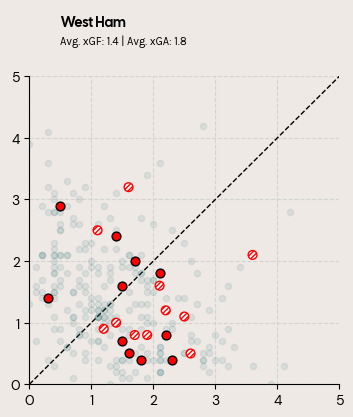

In [10]:
fig,ax=plt.subplots(figsize=(4,4))
plot_scatter_xg(ax, team_id=231497, color='red', label_x=False, label_y=False)
teamId=231497



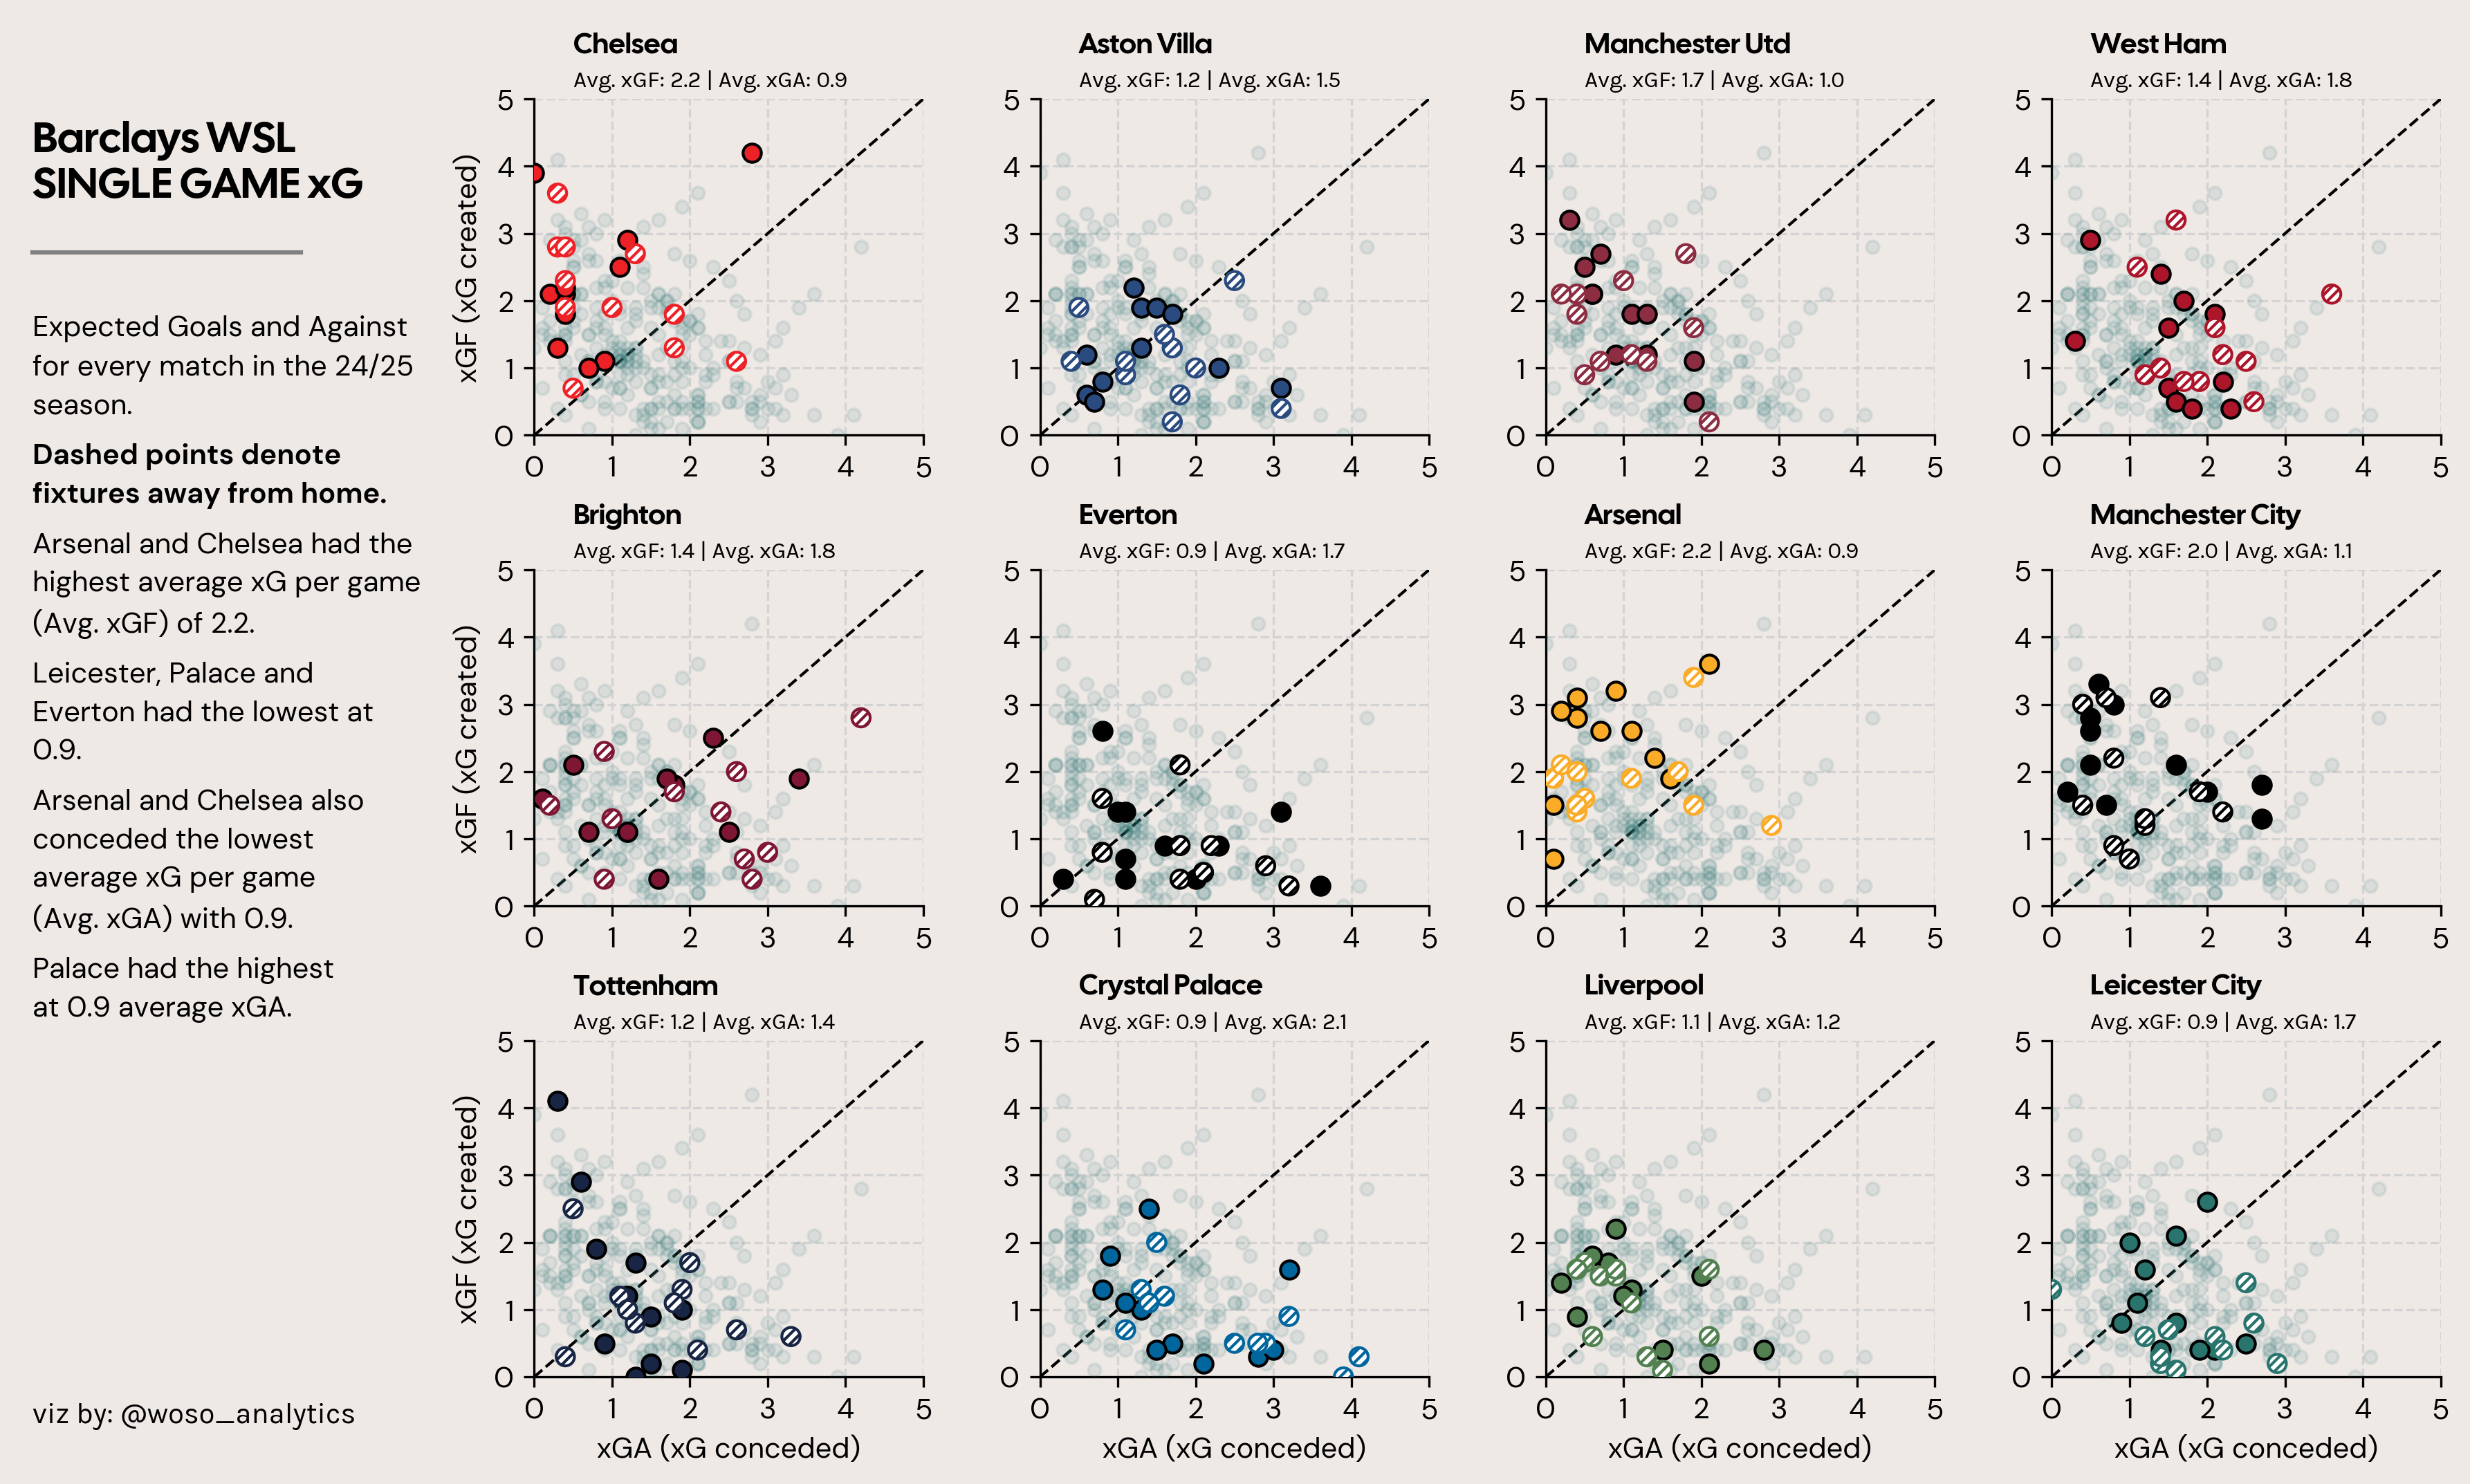

In [12]:
# layout = '''
#     ABCD
#     AEFG
#     AHIJ
#     AKLM
# '''

layout = '''
    ABCDE
    AFGHI
    AJKLM
'''

fig = plt.figure(figsize=(15,8), dpi=300)
ax_dict = fig.subplot_mosaic(layout, gridspec_kw={'hspace':.4, 'wspace':0.3})

counter = 0
for k, ax in ax_dict.items():
    if k == 'A':
        continue
    if counter == 0 or counter == 4 or counter == 8:
        label_y = True
    else:
        label_y = False
    if counter == 8 or counter == 9 or counter == 10 or counter == 11:
        label_x = True
    else:
        label_x = False
    teamId = df.team_id.unique()[counter]
    plot_scatter_xg(ax=ax, team_id=teamId, color=top_10_colors[counter], label_x=label_x, label_y=label_y)
    counter += 1


# Chart Legend and Title
ax_dict['A'].set_xlim(0,1)
ax_dict['A'].set_ylim(0,1)

ax_dict['A'].annotate(
    xy=(.01,.95),
    text='Barclays WSL\nSINGLE GAME xG',
    ha='left',
    va='center',
    weight='bold',
    font='Cal Sans',
    size=15
)

ax_dict['A'].plot(
    [.01,.7],
    [.88, .88],
    color='grey'
)

string_label = '''
Expected Goals and Against 
for every match in the 24/25
season. 

<Dashed points denote>
<fixtures away from home.>

Arsenal and Chelsea had the 
highest average xG per game
(Avg. xGF) of 2.2. 

Leicester, Palace and
Everton had the lowest at
0.9.

Arsenal and Chelsea also
conceded the lowest
average xG per game
(Avg. xGA) with 0.9. 

Palace had the highest
at 0.9 average xGA.
\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n
\n\n\n\n\n
<viz by: @woso_analytics>
'''

bbox_pad = 1.5
bboxprops = {'linewidth': 0, 'pad': bbox_pad}

ax_text(
    x=.01, y=.84,
    s=string_label,
    ax=ax_dict['A'],
    family='DM Sans',
   highlight_textprops=[
        {'weight':'bold'},
        {'weight':'bold'},
        {'family': 'Karla'},
    ]
)

ax_dict['A'].set_axis_off()

plt.savefig(
	"../figures/wsl_scatter_layout_1.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"../figures//wsl_scatter_layout_1.png_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

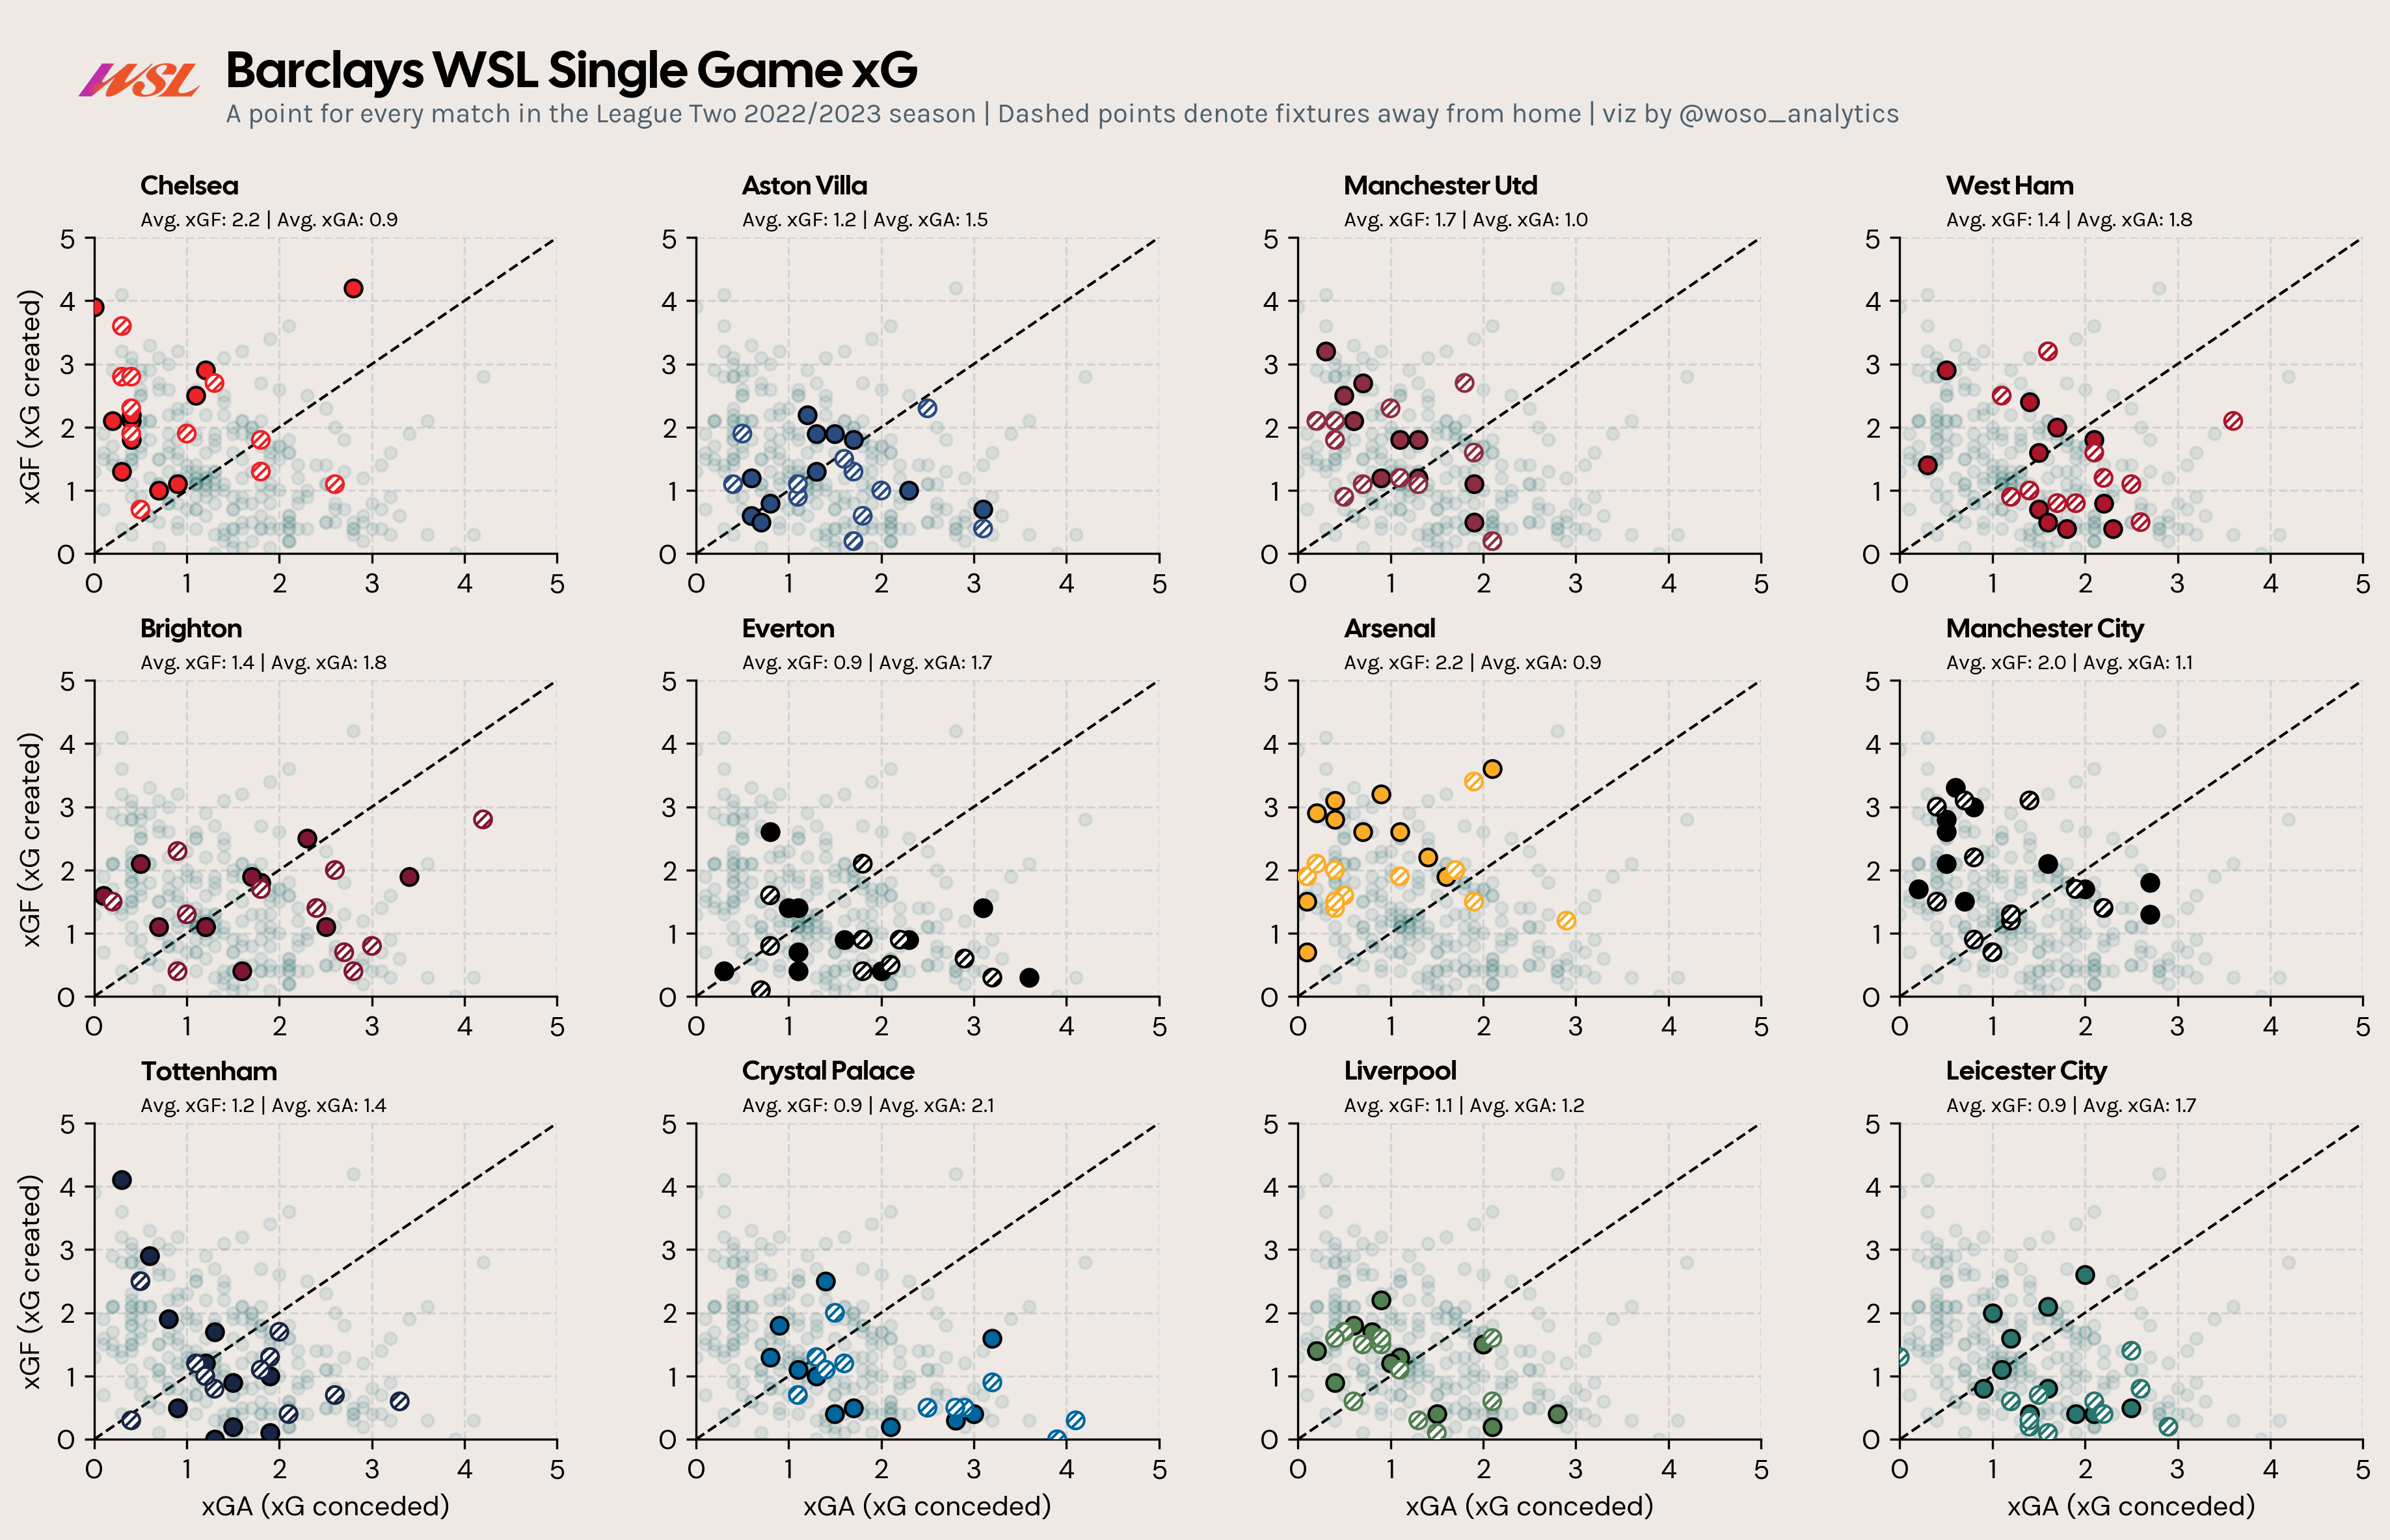

In [13]:

layout = '''
    BCDE
    FGHI
    JKLM
'''

fig = plt.figure(figsize=(15,8), dpi=300)
ax_dict = fig.subplot_mosaic(layout, gridspec_kw={'hspace':.4, 'wspace':0.3})

counter = 0
for k, ax in ax_dict.items():
    if counter == 0 or counter == 4 or counter == 8:
        label_y = True
    else:
        label_y = False
    if counter == 8 or counter == 9 or counter == 10 or counter == 11:
        label_x = True
    else:
        label_x = False
    teamId = df.team_id.unique()[counter]
    plot_scatter_xg(ax=ax, team_id=teamId, color=top_10_colors[counter], label_x=label_x, label_y=label_y)
    counter += 1

fig_text(
    x=0.17, y=.97, 
    s='Barclays WSL Single Game xG',
    va='bottom', ha='left',
    fontsize=19, color='black', font='Cal Sans', weight='bold'
)
fig_text(
	x=0.17, y=.95, 
    s='A point for every match in the League Two 2022/2023 season | Dashed points denote fixtures away from home | viz by @woso_analytics',
	va='bottom', ha='left',
	fontsize=10, color='#4E616C', font='Karla'
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/'
logo_ax = fig.add_axes(
    [.1, .94, .08, .08]
)
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{9227:.0f}.png'))
logo_ax.imshow(club_icon)
logo_ax.axis('off')

plt.savefig(
	"../figures/16062022_wsl_scatter_layout_2.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"../figures/16062022_wsl_scatter_layout_2_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)